In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import yaml
import os
import shutil

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from dataset.regressor_dataset import RegressorDataset

import matplotlib.pyplot as plt
plt.style.use("seaborn")
# import models.complementary_basemodel
# from loss.nt_xent import NTXentLoss

# import importlib
# importlib.reload(data_aug.complement_dataset)
# importlib.reload(models.complementary_basemodel)

## Creating Train Combos

In [48]:
df = pd.read_csv("data/train.csv")

In [49]:
# As nice as it is to have extra info, if the col is mostly null, I'm not interested
df = df[[c for c in df.columns if pd.isnull(df[c]).sum() < df.shape[0] - 100]]

In [50]:
cat_subset = pd.Series(df.dtypes[df.dtypes == "object"].index).sample(3).tolist()
df = df[df.dtypes[df.dtypes != "object"].index.tolist() + cat_subset]

In [51]:
cont_cols = df.dtypes[df.dtypes != "object"].index.tolist()
cat_cols = df.dtypes[df.dtypes == "object"].index.tolist()

#### Continuous Features

In [52]:
# For continuous features, impute the mean
for c in cont_cols:
    df[c] = df[c].fillna(df[c].mean())

In [53]:
# Standard Scaling
ss = StandardScaler()

scaled = df.drop(cat_cols, axis=1)
scaled = pd.DataFrame(ss.fit_transform(scaled), index=df.index, columns=scaled.columns)

df = pd.concat([df[cat_cols], scaled], axis=1)

#### Categorical Features

In [54]:
for c in cat_cols:
    df[c] = df[c].fillna(-1).astype(str)

In [55]:
oe = OrdinalEncoder()

encoded = df.drop(cont_cols, axis=1)
encoded = pd.DataFrame(oe.fit_transform(encoded), index=df.index, columns=encoded.columns)

df = pd.concat([df[cont_cols], encoded], axis=1)

## Train Test Split

In [56]:
# categorical_col_info
categorical_col_info = {cat_name: len(categories) for cat_name, categories in zip(cat_cols, oe.categories_)}

categorical_feature_names = list(categorical_col_info.keys())

embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) 
                   for _,n_categories in categorical_col_info.items()]

In [57]:
non_model_features = ["Id", "SalePrice"]

y = df["SalePrice"]
X = df.drop(non_model_features, axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [59]:
# Create the Datasets
train_data = RegressorDataset(X_train, y_train, categorical_feature_names)
test_data = RegressorDataset(X_test, y_test, categorical_feature_names)

## Training Model

In [60]:
# Continuous Features
n_cont = X_train.drop(categorical_feature_names, axis=1).shape[1]
n_cont

36

In [61]:
config = {
    "batch_size": 16,
    "epochs": 10,
    "num_batches_per_epoch": 200,
    "eval_every_n_epochs": 1,
    "fine_tune_from": "None",
    "log_every_n_steps": 5,
    "model": {
        "n_cont": n_cont,
        "embedding_sizes": embedding_sizes,
        "out_dim": 1  # it's a regression problem
    }
}

In [62]:
train_loader = DataLoader(train_data, batch_size=config["batch_size"],
                         shuffle=True)
valid_loader = DataLoader(test_data, batch_size=config["batch_size"],
                         shuffle=True)

In [63]:
# def _save_config_file(model_checkpoints_folder):
#     if not os.path.exists(model_checkpoints_folder):
#         os.makedirs(model_checkpoints_folder)
#         shutil.copy(
#             "./config.yaml",
#             os.path.join(model_checkpoints_folder, "config.yaml"),
#         )

In [64]:
from models.embedding_basemodel import EmbeddingBaseModel
# from complement import Complement

In [79]:
class Regressor:
    def __init__(self, config):
        self.config = config
        self.device = self._get_device()
        self.writer = SummaryWriter()
        self.loss = MSELoss()

    def _get_device(self):
        device = "cuda" if torch.cuda.is_available() else "cpu"
        print("Running on:", device)
        return device

    def train(self, train_loader, valid_loader):

        model = EmbeddingBaseModel(**self.config["model"]).to(self.device)
#         model = self._load_pre_trained_weights(model)

        optimizer = torch.optim.Adam(model.parameters(), 
                                    1e-4)

#         model_checkpoints_folder = os.path.join(
#             self.writer.log_dir, "checkpoints"
#         )

        # save config file
#         _save_config_file(model_checkpoints_folder)

        n_iter = 0
        valid_n_iter = 0
        best_valid_loss = np.inf

        for epoch_counter in tqdm(range(self.config["epochs"]), desc="epochs"):
            for data, label in tqdm(train_loader, desc="batches"):

                optimizer.zero_grad()

                loss = self._step(model, data, label, n_iter)
                
                break

                if n_iter % self.config["log_every_n_steps"] == 0:
                    print("Train Loss: {:.2f}".format(loss))
#                     self.writer.add_scalar(
#                         "train_loss", loss, global_step=n_iter
#                     )

                loss.backward()

                optimizer.step()
                n_iter += 1

#                 if n_iter % self.config["num_batches_per_epoch"] == 0:
#                     break

            # validate the model if requested
            if epoch_counter % self.config["eval_every_n_epochs"] == 0:
                valid_loss = self._validate(model, valid_loader)
                print("----VALID LOSS: " + str(valid_loss) + "----")
                if valid_loss < best_valid_loss:
                    # save the model weights
                    best_valid_loss = valid_loss
#                     torch.save(
#                         model.state_dict(),
#                         os.path.join(model_checkpoints_folder, "model.pth"),
#                     )

#                 self.writer.add_scalar(
#                     "validation_loss", valid_loss, global_step=valid_n_iter
#                 )
                valid_n_iter += 1
        
        return model


    def _load_pre_trained_weights(self, model):
        try:
            checkpoints_folder = os.path.join(
                "./runs", self.config["fine_tune_from"], "checkpoints"
            )
            state_dict = torch.load(
                os.path.join(checkpoints_folder, "model.pth")
            )
            model.load_state_dict(state_dict)
            print("Loaded pre-trained model with success.")
        except FileNotFoundError:
            print("Pre-trained weights not found. Training from scratch.")

        return model

    def _step(self, model, data, label, n_iter):
        """
        Calculate the loss on the batch
        """

        cont = data[0].to(self.device)
        cat = data[1].to(self.device)
        label = label.to(self.device).float()

        h1 = model(cont, cat)

        loss = self.loss(h1, label)

        return loss

    def _validate(self, model, valid_loader):

        # validation steps
        with torch.no_grad():
            model.eval()

            valid_loss = 0.0
            for counter, (data, label) in enumerate(valid_loader):

                loss = self._step(model, data, label, counter)

                valid_loss += loss.item()

#                 if counter > 10:
#                     break

            valid_loss /= counter
        model.train()
        return valid_loss


In [80]:
model = Regressor(config)

Running on: cpu


In [81]:
model = model.train(train_loader, valid_loader)

batches:   0%|          | 0/73 [00:00<?, ?it/s]


2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([4, 36])
torch.Size([4, 3])
----VALID LOSS: 1.304366992579566----
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 

batches:   0%|          | 0/73 [00:00<?, ?it/s]

batches:   0%|          | 0/73 [00:00<?, ?it/s]

2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([4, 36])
torch.Size([4, 3])
----VALID LOSS: 1.254638026158015----
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([4, 3


batches:   0%|          | 0/73 [00:00<?, ?it/s]

batches:   0%|          | 0/73 [00:00<?, ?it/s]

----VALID LOSS: 1.2605650623639424----
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([4, 36])
torch.Size([4, 3])
----VALID LOSS: 1.281115483906534----
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])



batches:   0%|          | 0/73 [00:00<?, ?it/s]


2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([4, 36])
torch.Size([4, 3])
----VALID LOSS: 1.25862355530262----
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 3


epochs: 100%|██████████| 10/10 [00:00<00:00, 10.28it/s]

2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([4, 36])
torch.Size([4, 3])
----VALID LOSS: 1.2449223515060213----
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16, 36])
torch.Size([16, 3])
2
torch.Size([16,

In [68]:
test_loader = DataLoader(RegressorDataset(X_test, None, categorical_feature_names),
                         batch_size=config["batch_size"],
                         shuffle=False)

In [69]:
predictions = []

model.eval()
for cont, cat in test_loader:
    predictions.extend(model(cont, cat).detach().numpy())

In [70]:
predictions = np.array(predictions).ravel()

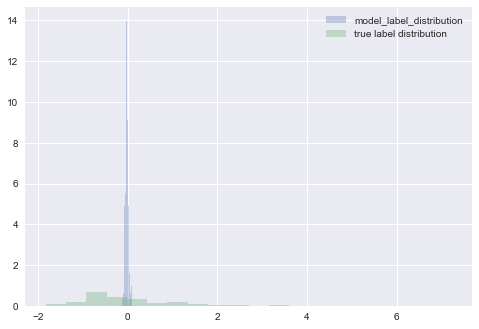

In [71]:
pd.Series(predictions).hist(bins=20, alpha=0.3, density=True,
                            label="model_label_distribution")
y_test.hist(bins=20, alpha=0.3, density=True,
            label="true label distribution")
plt.legend()